## 1D linear operator with a zero parameter

We have shown that parameter estimation works well with positive parameters. In some complex problems, one might include some extra terms in the predicted function, whose parameter equals to 0 in the end. To check if the framework works in such case, we construct the following example:

\begin{align*}
\mathcal{L}_x^\phi &:= \phi_1 \cdot + \phi_2\frac{d}{dx}\cdot + \phi_3\frac{d^2}{dx^2}\cdot \\
u(x) &= sin(x) \\
f(x) &= \mathcal{L}_x^\phi u(x)\\
&=\phi_1 sin(x) + \phi_2 cos(x) - \phi_3 sin(x) \\
&=(\phi_1- \phi_3)sin(x) + \phi_2 cos(x) \\
x &\in [0, 1] \\
\end{align*}

#### Simulate data
We assume $\phi_1 = 2$ and $\phi_3 = 5$, and $cos(x)$ is the extra term with $\phi_2 = 0$, then the final solution is:

\begin{align*}
f(x) &= -3sin(x) 
\end{align*}

In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
x = np.random.rand(20)
phi1 = 2.0
phi2 = 0.0
phi3 = 5.0
y_u = np.sin(x)
y_f = phi1*np.sin(x) + phi2*np.cos(x) - phi3*np.sin(x)

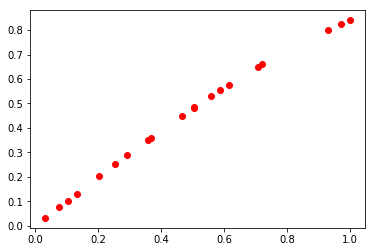

In [3]:

plt.plot(x, y_u, 'ro')
plt.show()

#### Evaluate kernels
Corresponding kernels are defined as following:

$k _ { u u } \left( x _ { i } , x _ { j } ; \theta \right) = \theta \exp \left( - \frac { 1 } { 2 l } \left( x _ { i } - x _ { j } \right) ^ { 2 } \right)$

$\left. \begin{array} { l } { k _ { f f } \left( x _ { i } , x _ { j } ; \theta , \phi _ { 1 } , \phi _ { 2 } , \phi _ { 3 } \right) } \\ { = \mathcal { L } _ { x _ { i } } ^ { \phi } \mathcal { L } _ { x _ { j } } ^ { \phi } k _ { u u } \left( x _ { i } , x _ { j } ; \theta \right) } \\ { = \mathcal { L } _ { x _ { i } } ^ { \phi } \left( \phi _ { 1 } k _ { u u } + \phi _ { 2 } \frac { \partial } { \partial x _ { j } } k _ { u u } + \phi _ { 3 } \frac { \partial ^ { 2 } } { \partial x _ { j } ^ { 2 } } k _ { u u } \right) } \\ { = \left( \phi _ { 1 } k _ { u u } + \phi _ { 2 } \frac { \partial } { \partial x _ { i } } k _ { u u } + \phi _ { 3 } \frac { \partial ^ { 2 } } { \partial x _ { i } ^ { 2 } } k _ { u u } \right) \left( \phi _ { 1 } k _ { u u } + \phi _ { 2 } \frac { \partial } { \partial x _ { j } } k _ { u u } + \phi _ { 3 } \frac { \partial ^ { 2 } } { \partial x _ { j } ^ { 2 } } k _ { u u } \right) } \end{array} \right.$

$\left. \begin{array} { l } { k _ { f u } \left( x _ { i } , x _ { j } ; \theta , \phi _ { 1 } , \phi _ { 2 } , \phi _ { 3 } \right) } \\ { = \mathcal { L } _ { x _ { i } } ^ { \phi } k _ { u u } \left( x _ { i } , x _ { j } ; \theta \right) } \\ { = \phi _ { 1 } k _ { u u } + \phi _ { 2 } \frac { \partial } { \partial x _ { i } } k _ { u u } + \phi _ { 3 } \frac { \partial ^ { 2 } } { \partial x _ { i } ^ { 2 } } k _ { u u } } \end{array} \right.$

$\left. \begin{array} { l } { k _ { u f } \left( x _ { i } , x _ { j } ; \theta , \phi _ { 1 } , \phi _ { 2 } , \phi _ { 3 } \right) } \\ { = \mathcal { L } _ { x _ { i } } ^ { \phi } k _ { u u } \left( x _ { i } , x _ { j } ; \theta \right) } \end{array} \right.$ 

In [4]:
x_i, x_j, theta, phi1, phi2, phi3 = sp.symbols('x_i x_j theta phi1 phi2 phi3')
kuu_sym = sp.exp(theta*(-1)/(2)*((x_i - x_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, theta), kuu_sym, "numpy")
def kuu(x, theta):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], theta)
    return k

$k_{ff}(x_i,x_j;\theta,\phi_1, \phi_2,\phi_3) \\
= \mathcal{L}_{x_i}^\phi \mathcal{L}_{x_j}^\phi k_{uu}(x_i, x_j; \theta) \\
= \mathcal{L}_{x_i}^\phi \left( \phi_1 k_{uu} + \phi_2 \frac{\partial}{\partial x_j}k_{uu} +\phi_3 \frac{\partial^2}{\partial x_j^2}k_{uu} \right) \\
=( \phi_1 k_{uu} + \phi_2 \frac{\partial}{\partial x_i}k_{uu} +\phi_3 \frac{\partial^2}{\partial x_i^2}k_{uu})( \phi_1 k_{uu} + \phi_2 \frac{\partial}{\partial x_j}k_{uu} +\phi_3 \frac{\partial^2}{\partial x_j^2}k_{uu})  $

In [5]:
kff_sym = phi1**2*kuu_sym + phi1*phi2*sp.diff(kuu_sym, x_j) + phi1*phi3*sp.diff(kuu_sym, x_j, x_j) \
+ phi1*phi2*sp.diff(kuu_sym, x_i) + phi2**2*sp.diff(kuu_sym, x_i, x_j) + phi2*phi3* sp.diff(kuu_sym, x_i,x_j, x_j)\
+ phi1*phi3*sp.diff(kuu_sym, x_i, x_i)+phi2*phi3* sp.diff(kuu_sym, x_i,x_i, x_j)+phi3*phi3* sp.diff(kuu_sym,x_i, x_i,x_j, x_j)
kff_fn = sp.lambdify((x_i, x_j, theta, phi1,phi2,phi3), kff_sym, "numpy")
def kff(x, theta, phi1, phi2,phi3):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], theta, phi1, phi2, phi3)
    return k

$k_{fu}(x_i,x_j;\theta,\phi_1, \phi_2,\phi_3) \\
= \mathcal{L}_{x_i}^\phi k_{uu}(x_i, x_j; \theta) \\
= \phi_1 k_{uu} + \phi_2 \frac{\partial}{\partial x_i}k_{uu}+\phi_3 \frac{\partial^2}{\partial x_i^2}k_{uu}$

In [6]:
kfu_sym = phi1*kuu_sym + phi2*sp.diff(kuu_sym, x_i)+ phi3*sp.diff(kuu_sym, x_i, x_i)
kfu_fn = sp.lambdify((x_i, x_j, theta, phi1, phi2,phi3), kfu_sym, "numpy")
def kfu(x1, x2, theta, phi1, phi2,phi3):
    k = np.zeros((x1.size, x2.size))
    for i in range(x1.size):
        for j in range(x2.size):
            k[i,j] = kfu_fn(x1[i], x2[j], theta, phi1, phi2,phi3)
    return k

$k_{uf}(x_i,x_j;\theta,\phi_1, \phi_2,\phi_3) \\
= \mathcal{L}_{x_j}^\phi k_{uu}(x_i, x_j; \theta) $ 


In [7]:
def kuf(x1, x2, theta, phi1, phi2,phi3):
    return kfu(x1,x2,theta,phi1, phi2,phi3).T

#### step 3: define negative log marginal likelihood  



$K = \begin{bmatrix}
k_{uu}(X_u, X_u; \theta) + \sigma_u^2I & k_{uf}(X_u, X_f; \theta, \phi) \\
k_{fu}(X_f, X_u; \theta, \phi) & k_{ff}(X_f, X_f; \theta, \phi) + \sigma_f^2I
\end{bmatrix}$

For simplicity, assume $\sigma_u = \sigma_f$.

$\mathcal{NLML} = \frac{1}{2} \left[ log|K| + y^TK^{-1}y + Nlog(2\pi) \right]$

where $y = \begin{bmatrix}
y_u \\
y_f
\end{bmatrix}$

In [8]:
def nlml(params, x1, x2, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [kuu(x1, params[0]) + s*np.identity(x1.size), kuf(x1, x2, params[0], params[1], params[2], params[3])],
        [kfu(x1, x2, params[0], params[1], params[2], params[3]), kff(x2, params[0], params[1], params[2], params[3])\
         + s*np.identity(x2.size)]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [9]:
nlml((1,2,0,5), x, x, y_u, y_f, 1e-7)


36468.690188550885

#### Optimise hyperparameters


In [10]:
m = minimize(nlml, np.random.rand(4), args=(x, x, y_u, y_f, 1e-7), method="Nelder-Mead")
m

 final_simplex: (array([[ -1.47463694,  -5.29166242, -10.89281252,   1.10033754],
       [ -1.46817998,  -5.11598219, -10.60706109,   1.10072159],
       [ -1.47254863,  -5.1254956 , -10.62591272,   1.10052017],
       [ -1.46861919,  -5.06459858, -10.52555486,   1.10067852],
       [ -1.47381445,  -4.97714942, -10.3891964 ,   1.10100227]]), array([-272.60168991, -272.60022835, -272.59924525, -272.59900154,
       -272.598892  ]))
           fun: -272.60168990963575
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 800
           nit: 480
        status: 1
       success: False
             x: array([ -1.47463694,  -5.29166242, -10.89281252,   1.10033754])

In [11]:

phi1 = np.exp(m.x[1]) ## phi1


In [12]:
phi2 = np.exp(m.x[2]) ## phi2

In [13]:
phi3 = np.exp(m.x[3]) ## phi3

$f(x) = \phi_1sin(x) + \phi_2 cos(x)- \phi_3sin(x)  $

$f(x) = (\phi_1- \phi_3)sin(x) + \phi_2 cos(x)  $

where $\phi_1- \phi_3$ should be around 2.0, and $\phi_2$ around 5.0

In [14]:
phi = [phi1 -phi3, phi2]

In [15]:
phi # [phi1 - phi3, phi2]

[-3.000146833148997, 1.8591380119754502e-05]